<a href="https://colab.research.google.com/github/Mofetoluwa/Detectron/blob/master/ED_IR_papers_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install unidecode
! pip install pillow
! pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 5.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# https://medium.com/python-pandemonium/never-write-for-loops-again-91a5a4c84baf

# Import libraries
import os
import json
import re
import math
import random
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from wordcloud import WordCloud, STOPWORDS

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

# Load IR Papers
with open("gdrive/MyDrive/papers_abs3_latest.json") as file:
  data = json.load(file)
  file.close()

# Load Semantic scholar papers
semantic_schol_data = {}
semschol_path = "gdrive/MyDrive/semantic_scholar"

for subdir, dir, files in os.walk(semschol_path):
  for file in files:
    with open(os.path.join(subdir, file)) as file:
      sem_data = json.load(file)
      semantic_schol_data.update(sem_data)

Mounted at /content/gdrive


In [4]:
# Load new data
with open("gdrive/MyDrive/filtered-paper.lingual.v2.json") as file:
  data1 = json.load(file)
  file.close()

with open("gdrive/MyDrive/filtered-paper.v2.json") as file:
  data2 = json.load(file)
  file.close()

def merge(d1, d2):
    new_d = {}
    conferences = list(set(d1) | set(d2))
    for conference in conferences:
        papers = [*d1.get(conference, []), *d2.get(conference, [])]
        if len(papers) == 0:
            continue
        new_d[conference] = papers
    return new_d

new_data = merge(data1, data2)

In [5]:
# Sort semantic Scholar data
sem_confs = ["EMNLP", "NAACL", "ACL", "CoNNL", "EACL", "AAAI",
             "SIGIR", "COLING", "CLEF", "WSDM", "TOIS", "ICML",
             "WWW", "TREC", "FIRE", "NTCIR", "Web Search and Data Mining",
             "Text Retrieval Conference", "CIKM"]

with_venue = 0
no_venue = 0
no_venue_papers = []

semantic_schol_sorted = {}
semantic_schol_sorted["others"] = []

for paper, paper_details in semantic_schol_data.items():
  if paper_details['venue'] == '':
    no_venue += 1
    no_venue_papers.append(paper_details)
  else:
    with_venue += 1
    added_ids = [] 
    for conf in sem_confs:
      if paper_details['venue'] == conf or re.search(f"[^a-zA-Z]{conf}", 
                                                      paper_details['venue']):
        added_ids.append(paper)
        if conf not in semantic_schol_sorted:
          semantic_schol_sorted[conf] = []
          semantic_schol_sorted[conf].append(paper_details)
        else:
          semantic_schol_sorted[conf].append(paper_details)
    if paper not in added_ids:
      semantic_schol_sorted["others"].append(paper_details)
        

semantic_schol_sorted['WSDM'] = semantic_schol_sorted['Web Search and Data Mining']
semantic_schol_sorted['TREC'].extend(semantic_schol_sorted['Text Retrieval Conference'])
semantic_schol_sorted['others'].extend(no_venue_papers)

del semantic_schol_sorted['Web Search and Data Mining']
del semantic_schol_sorted['Text Retrieval Conference']

print(f"Papers with Venue: {with_venue}")
print(f"Papers without Venue: {no_venue}")

Papers with Venue: 838
Papers without Venue: 595


In [ ]:
"""for conf in semantic_schol_sorted:
  if conf not in data:
    years = 
    check_years = list()
    for paper in semantic_schol_sorted[conf]:
      if paper['year'] not in years:"""

In [ ]:
# View data
subset = dict(list(data.items())[:1])
print(json.dumps(subset, indent=4))

In [ ]:
conf_counts = {}

for conf in data:
  conf_count = 0
  for year in data[conf]:
    paper_count = len(data[conf][year])
    conf_count += paper_count

  conf_counts[conf] = conf_count

conf_counts

In [6]:
# Check total no. of papers
# Check papers without abstract
## Collect papers with abstracts by conference

num_papers_scrapped = 0
no_abstracts = 0
proceedings = 0

conf_papers_abstracts = {}
proceedings_workshops = []

for conf in data:
  papers = []
  abstracts = []
  for year in data[conf]:
    paper_count = len(data[conf][year])
    num_papers_scrapped += paper_count  

    for paper in data[conf][year]:        
      if "abstract" not in paper or paper["abstract"]==None:
        no_abstracts += 1
        if any(word_ in paper["title"].lower() for word_ in ['proceeding', 'workshop']):
          proceedings_workshops.append(paper)
          proceedings += 1         
      elif "abstract" in paper:
        papers.append(paper["title"])
        abstracts.append(paper["abstract"])
  conf_papers_abstracts[conf] = list(zip(papers, abstracts))

print(f"Total number of papers scrapped: {num_papers_scrapped}")
print(f"Total number of Proceedings: {proceedings}")
print(f"Papers without abstracts: {no_abstracts}")

Total number of papers scrapped: 50287
Total number of Proceedings: 899
Papers without abstracts: 13093


In [ ]:
# Check
"""for conf in data:
  for year in data[conf]:
    for paper in data[conf][year]:
      if "Making a MIRACL:" in paper['title']:
        print(paper)

for conf in semantic_schol_sorted:
  for paper in semantic_schol_sorted[conf]:
    if "Making a MIRACL:".lower() in paper['title'].lower():
      print(paper)"""

In [7]:
# Join semantic scholar and IR Anthology papers

semschol_papers_abstracts = {}
for conf, papers in semantic_schol_sorted.items():
  titles_ = []
  abstracts_ = []
  for paper in papers:
    titles_.append(paper['title'])
    abstracts_.append(paper['abstract'])
  semschol_papers_abstracts[conf] = list(zip(titles_, abstracts_))

  if conf not in conf_papers_abstracts:
    conf_papers_abstracts[conf] = semschol_papers_abstracts[conf]
  else:
    for paper, abstract in semschol_papers_abstracts[conf]:
      if (paper, abstract) not in conf_papers_abstracts[conf]:
        conf_papers_abstracts[conf].append((paper, abstract))

In [8]:
# Check
papers_abstracts_count = [len(papers) for conf, papers in conf_papers_abstracts.items()]
sum(papers_abstracts_count)

38550

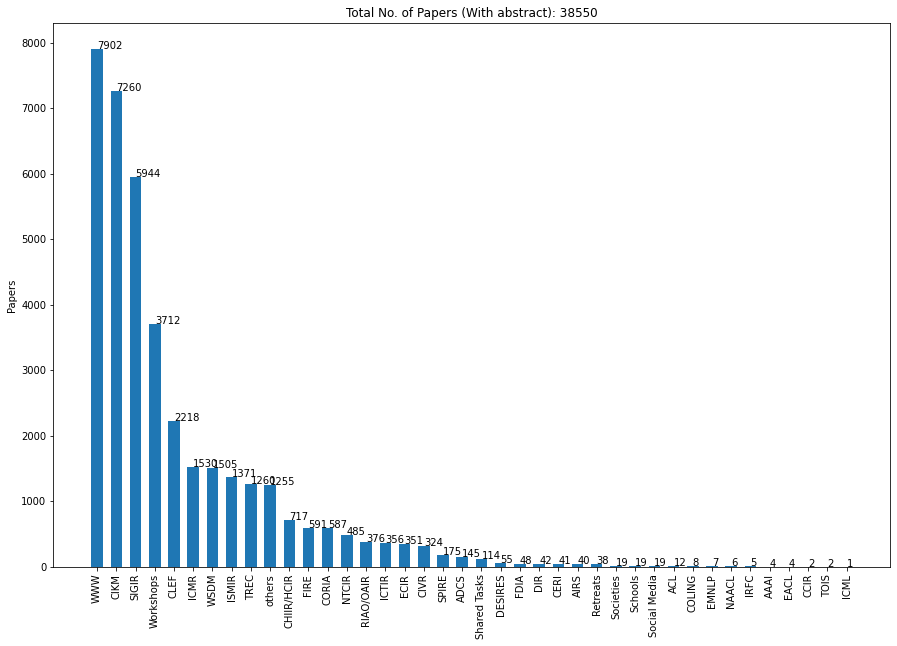

In [9]:
# View no. of papers per conf/sources
# Thoughts: Maybe add plot of papers without abstract per conf for compar.

conf_paper_count = {conf:len(papers) for conf,papers in conf_papers_abstracts.items()}
sorted_paper_count = dict(sorted(conf_paper_count.items(), key=lambda x:x[1], reverse=True))
total = sum(conf_paper_count.values())
sorted_confs = list(sorted_paper_count.keys())
sorted_counts = list(sorted_paper_count.values())

index = np.arange(len(sorted_confs))
plt.figure(figsize=(15, 10))
plt.bar(index, sorted_counts, 0.6)
for i, v in enumerate(sorted_counts):
    plt.text(i, v , str(v), color='black')
plt.xticks(index, sorted_confs, fontsize=10, rotation=90)
plt.ylabel('Papers', fontsize=10)
plt.title("Total No. of Papers (With abstract): {}".format(total))
plt.show()

In [10]:
# View relevant papers per conference i.e those with keywords. 
# Keywords considered: language(s), lingual 

# Check mono, multi and cross lingual
# Maybe also check abstracts with "retriev"

keywords = ['language', 'lingual']

mono_lingual = ["monolingual", "mono lingual", "mono-lingual"]
multi_lingual = ["multilingual", "multi lingual", "multi-lingual"]
cross_lingual = ["crosslingual", "cross lingual", "cross-lingual"]

def get_papers(dictionary: dict, keywords_: list):
  papers_returned = {}
  for conf, papers in dictionary.items():
    new_papers = []
    new_abstracts = []
    for paper, abstract in papers:
      if any(keyword.lower() in unidecode(abstract.lower()) for keyword in keywords_):
        new_papers.append(paper)
        new_abstracts.append(abstract)
    papers_returned[conf] = list(zip(new_papers, new_abstracts))
  return papers_returned

language_papers = get_papers(conf_papers_abstracts, keywords)

monolingual_papers = get_papers(language_papers, mono_lingual)
multilingual_papers = get_papers(language_papers, multi_lingual)
crosslingual_papers = get_papers(language_papers, cross_lingual)


In [11]:
lang_papers_count = {conf:len(papers) for conf,papers in language_papers.items()}
print(f"Total Number of Language papers: {sum(lang_papers_count.values())}")

mono_papers_count = {conf:len(papers) for conf,papers in monolingual_papers.items()}
print(f"Papers with Monolingual in Abstract: {sum(mono_papers_count.values())}")

multi_papers_count = {conf:len(papers) for conf,papers in multilingual_papers.items()}
print(f"Papers with Multilingual in Abstract: {sum(multi_papers_count.values())}")

cross_papers_count = {conf:len(papers) for conf,papers in crosslingual_papers.items()}
print(f"Papers with Crosslingual in Abstract: {sum(cross_papers_count.values())}")

Total Number of Language papers: 6764
Papers with Monolingual in Abstract: 601
Papers with Multilingual in Abstract: 1836
Papers with Crosslingual in Abstract: 477


In [12]:
retrieval_papers = get_papers(language_papers, ['retriev'])

retrieval_papers_count = {conf:len(papers) for conf,papers in retrieval_papers.items()}
print(f"Total Number of IR Language papers: {sum(retrieval_papers_count.values())}")

Total Number of IR Language papers: 3498


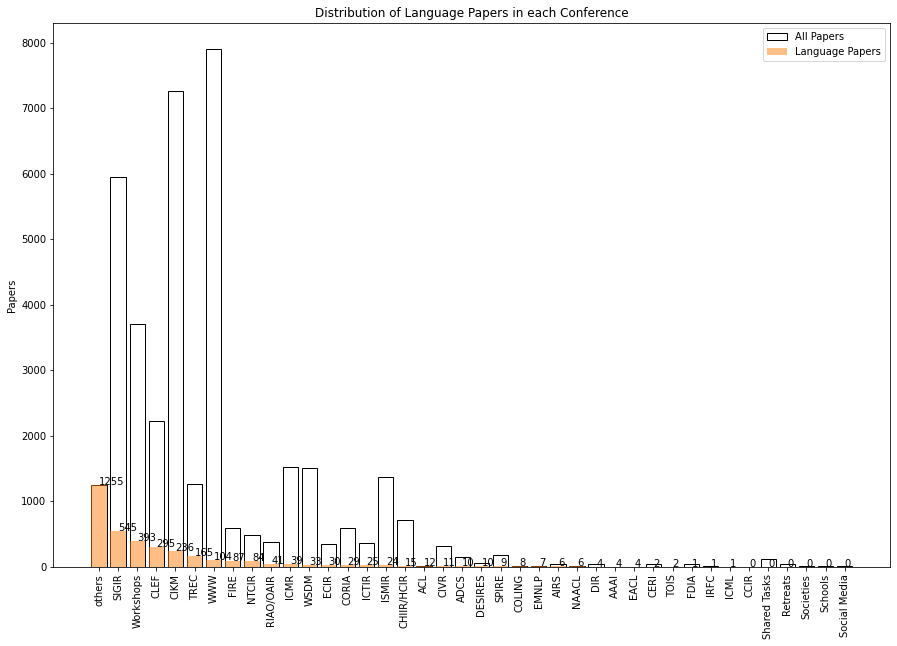

In [ ]:
# View language related papers per conference

width = 0.8
sorted_paper_count = dict(sorted(retrieval_papers_count.items(), 
                                 key=lambda x:x[1], reverse=True))

sorted_confs = list(sorted_paper_count.keys())
sorted_counts = list(sorted_paper_count.values())

total = sum(conf_paper_count.values())
#counts = list(conf_paper_count.values())
counts = [conf_paper_count[conf] for conf in sorted_confs]
total_lang_paper_count = sum(sorted_paper_count.values())

index = np.arange(len(sorted_confs))

plt.figure(figsize=(15, 10))
plt.bar(index, counts, width=width, fill=False, label='All Papers')
plt.bar(index, sorted_counts, width=width, alpha=0.5, label='Language Papers')
for i, v in enumerate(sorted_counts):
    plt.text(i, v , str(v), color='black')

plt.xticks(index, sorted_confs, fontsize=10, rotation=90)
plt.ylabel('Papers', fontsize=10)
plt.title("Distribution of Language Papers in each Conference")
plt.legend()
plt.show()

In [ ]:
def plot_subset(subset: dict, title: str):
  subset = dict(sorted(subset.items(), key=lambda x:x[1], 
                                  reverse = True))
  count = list(subset.values())
  confs = list(subset.keys())
  index = np.arange(len(confs))

  plt.figure(figsize=(15, 10))
  #plt.bar(index, lang_count, width=width, label='Language Papers')
  #plt.bar(index, count, width=width, alpha=0.5)
  plt.bar(index, count, alpha=0.5)
  #for i, v in enumerate(count):
  #    plt.text(i, v , str(v), color='black')

  plt.xticks(index, confs, fontsize=10, rotation=90)
  plt.ylabel('Count', fontsize=10)
  plt.title(title)
  #plt.legend()
  plt.show()

In [ ]:
# View Monolingual per conference

plot_subset(mono_papers_count, "Distribution of Papers with Monolingual in Abstract")

In [ ]:
# View Multilingual per conference

plot_subset(multi_papers_count, "Distribution of Papers with Multilingual in Abstract")

In [ ]:
# View Cross-lingual per conference

plot_subset(cross_papers_count, "Distribution of Papers with Crosslingual in Abstract")

### Language Analysis

In [13]:
# Get language list
insert = ['German', 'Luganda']
with open("gdrive/MyDrive/languages.txt") as file:
  languages = [language.rstrip() for language in file]
  languages.extend(insert)
  file.close()

In [14]:
len(languages)

7562

In [ ]:
languages.index('Hausa')

2233

In [ ]:
# Check for language classes
 
keywords = ['Afri', 'African']
afri_papers = get_papers(retrieval_papers, keywords)

afri_papers_count = {conf:len(papers) for conf,papers in afri_papers.items()}
print(f"Papers that mention African languages in Abstract: {sum(afri_papers_count.values())}")

Papers that mention African languages in Abstract: 5


In [ ]:
afri_papers #IsiZulu, Luganda

In [ ]:
# Check for xxx languages
multiple_languages = []
multiple_languages2 = []

for conf, papers in retrieval_papers.items():
  for paper, abstract in papers:
    match1 = re.search(f"[0-9]+ languages", abstract.lower())
    match2 = re.search(f"[0-9]+ [a-zA-Z]+ languages", abstract.lower())
    if match1:
      multiple_languages.append((paper, abstract, abstract[match1.start():match1.end()]))
    elif match2:
      multiple_languages2.append((paper, abstract, abstract[match2.start():match2.end()]))

In [ ]:
multiple_languages

In [ ]:
multiple_languages #108 Wiki, 112 Tatoeba, 101, 

In [16]:
Unwanted = ["English", "Day", "She", "Are", "Even","Male", "Dom", "Uni", 
            "Con", "Bit", "Label", "Siri", "Fore", "Indri", "Lingua Franca", 
            "Carrier", "Moi", "Mer", "Awa", "Bench", "Sam", "Mono", "Sake",
            "Col", "Aka", "Han", "Mor", "Gen", "Slave", "Tem", "Tira", "Notre",
            "Rang", "Blackfoot", "Ali", "Thompson", "Ese", "Pin", "Fur", "Nen",
            "American Sign Language", "Dia", "Jimi", "Ami", "Titan", "Nara", "Tha",
            "Uri", "Moba", "Mum", "Uda", "Dene", "Efe", "Mpi", "Nii", "Dene", "Gana",
            "Latin"]

In [ ]:
sanity_check = []
for language in languages:
  if len(language) >= 3 and language not in Unwanted:
    for conf, papers in retrieval_papers.items():
      for paper, abstract in papers:
        abstract_ = re.sub(r'[^\w\s]', '', abstract.lower())
        abstract_ = abstract_.split()
        if language.lower() in abstract_ and 'lingual' not in abstract.lower():
          sanity_check.append((language, paper, abstract))

In [ ]:
sanity_check[200:210]

In [ ]:
# Total language counts
total_lang_counts = {}
for language in languages:
  if len(language) >= 3 and language not in Unwanted:
    unique_lang_papers = []
    lang_papers = get_papers(retrieval_papers, [language])
    for conf, papers in lang_papers.items():
      for paper, abstract in papers:
        if re.search(f"[\s(/-]{language.lower()}[\s,/)\?\.-]",
                     unidecode(abstract.lower())):
          if paper not in unique_lang_papers:
            unique_lang_papers.append(paper)
    if len(unique_lang_papers) > 0:
      total_lang_counts[language] = len(unique_lang_papers)
          

In [ ]:
# Plot languages by counts 
total_lang_counts = dict(sorted(total_lang_counts.items(), key=lambda x:x[1], reverse=True))
total_lang_counts_sub = dict(zip(list(total_lang_counts.keys())[:45], 
                             list(total_lang_counts.values())[:45]))
plot_subset(total_lang_counts_sub, "Total Language Occurence")

In [ ]:
#total_lang_counts
total_lang_counts

In [22]:
language_speakers = pd.read_csv("gdrive/MyDrive/language_speakers2-2.csv")
language_speakers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  0 non-null      float64
 1   language    99 non-null     object 
 2   resources   99 non-null     int64  
 3   speakers    66 non-null     float64
 4   wikipedia   67 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 4.0+ KB


In [13]:
# No of speakers for languages

language_speakers = pd.read_csv("gdrive/MyDrive/language_speakers2-2.csv")
language_speakers.drop(['Unnamed: 0'], axis=1, inplace=True)
language_speakers.dropna(inplace=True)
speakers = language_speakers['speakers'].values[:45]


def plot_subset2(subset: dict, title: str):
  subset = dict(sorted(subset.items(), key=lambda x:x[1], 
                                  reverse = True))
  count = list(subset.values())
  confs = list(subset.keys())
  index = np.arange(len(confs))

  plt.figure(figsize=(15, 10))
  colours = []
  labels = []
  for i, lang in enumerate(confs):
    if speakers[i] >= 150:
      colours.append('green')
      labels.append('Speakers =< 150M')
    elif 50 < speakers[i] < 150:
      colours.append('orange')
      labels.append('150M > Speakers > 50M')
    else:
      colours.append('red') 
      labels.append('Speakers >= 50M')
  
  plt.bar(index, count, color=colours, label=labels)
  col_labels = {'Speakers <= 150M':'green', '150M > Speakers > 50M':'orange',
                'Speakers >= 50M':'red'}
  labels_ = list(col_labels.keys())
  handles = [plt.Rectangle((0,0),1,1, color=col_labels[label_]) for label_ in labels_]
  plt.legend(handles, labels_)

  plt.xticks(index, confs, fontsize=10, rotation=90)
  plt.ylabel('Count', fontsize=10)
  plt.title(title)
  #plt.legend()
  plt.show()

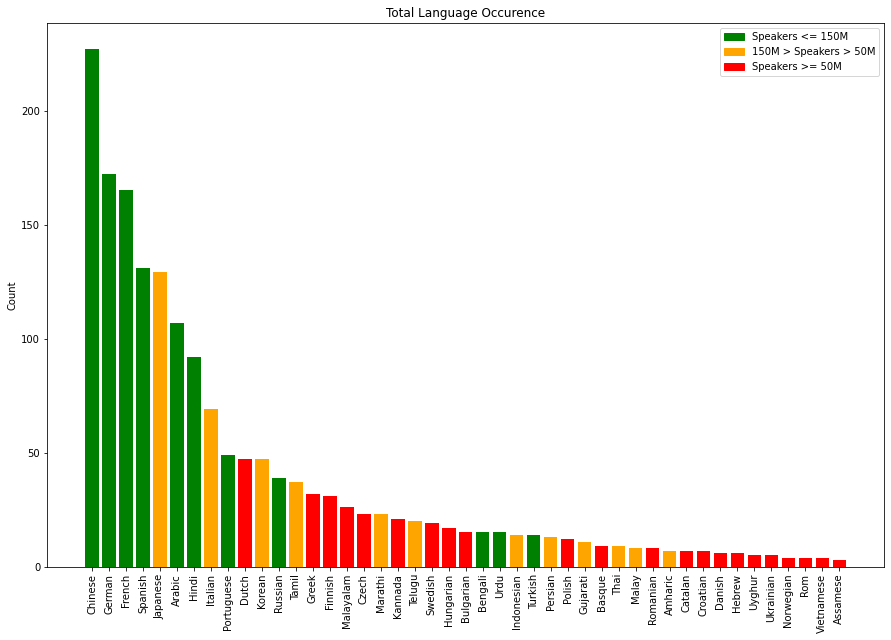

In [ ]:
# Bar Plot
plot_subset2(total_lang_counts_sub, "Total Language Occurence")

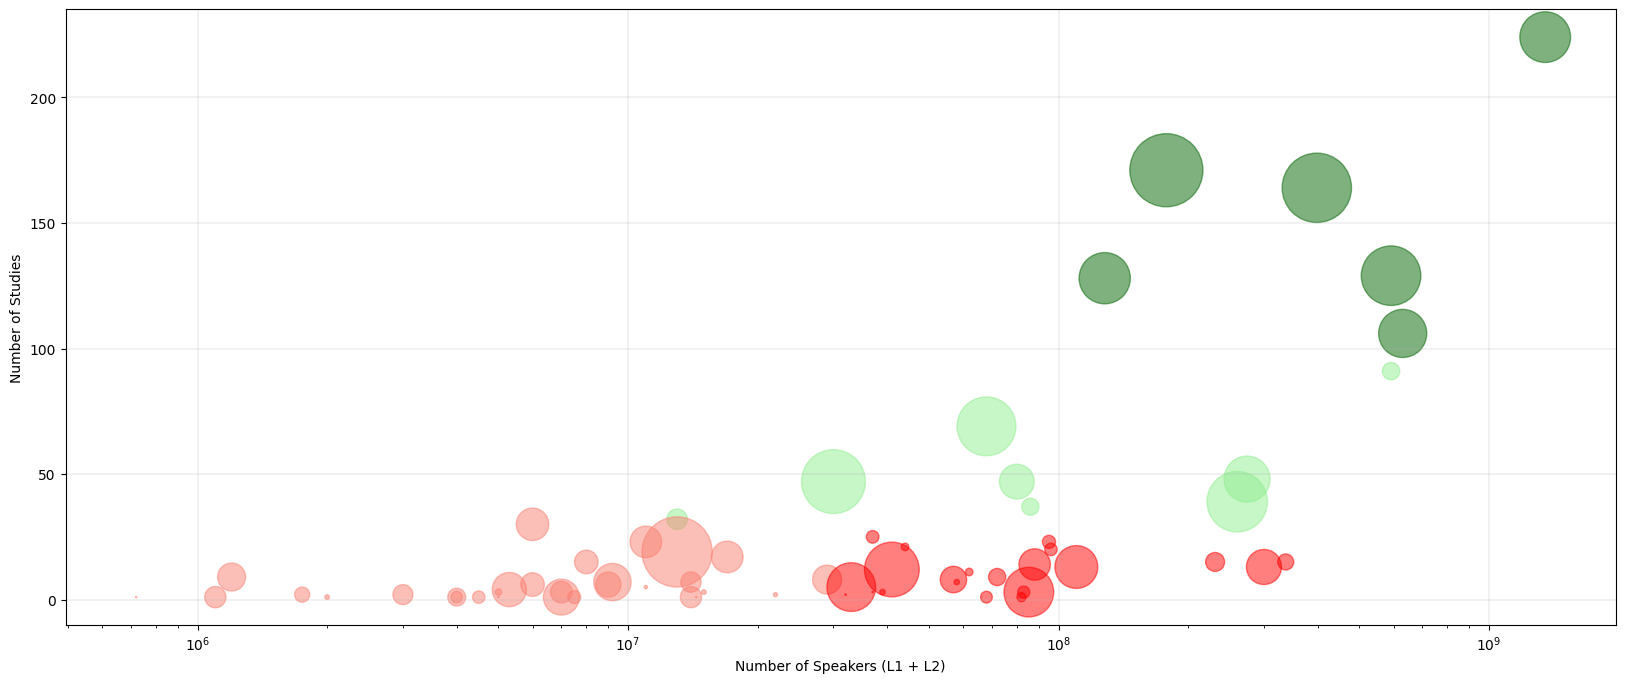

In [17]:
# Scatter plot
plt.figure(figsize=(20, 8))
plt.style.use('default')

resources_ = list(language_speakers['resources'])
speakers_ = list(language_speakers['speakers'].values)
wiki_ = list(language_speakers['wikipedia'].values)
classes = []
sizes = []

for i,_ in enumerate(resources_):
  # Class 1: many speakers, many resources
  if speakers_[i] >= 30 and resources_[i] >= 100:
    classes.append('darkgreen') # Green
    #sizes.append(120)
  elif speakers_[i] >= 30 and resources_[i] < 30:
    classes.append('red') # red
    #sizes.append(90)
  #elif speakers_[i] >= 10 and resources_[i] < 30:
  #  classes.append('red') # red
  #  sizes.append(75)
  elif speakers_[i] > 10 and 29 <= resources_[i] < 100:
    classes.append('lightgreen') # Light green
    #sizes.append(80)
  elif speakers_[i] <= 30 and resources_[i] <= 30:
    classes.append('salmon') # Orange
    #sizes.append(50)
  sizes.append(wiki_[i])

speakers_ = np.array(speakers_) * 1e06

plt.scatter(speakers_, resources_, s=sizes, c=classes, alpha=0.5, cmap='RdYlGn')
plt.xscale('log')
plt.xlim((7e05, 14e08))
plt.ylim((0, 400))
plt.yticks(range(0, 400, 50))
#plt.xticks(range(int(7e05), int(14e08), int(1e06)))
plt.autoscale(True)
plt.grid(linewidth=0.25)
plt.xlabel("Number of Speakers (L1 + L2)")
plt.ylabel("Number of Studies")



plt.show()

In [ ]:
# Get Bar chart by continent

Continents_languages = {
    'Asia': ['Chinese', 'Japanese', 'Tagalog', 'Sanskrit',
             'Pinyin', 'Kyrgyz', 'Kazakh', 'Javanese', 'Arabic',
             'Korean', 'Tamil', 'Marathi', 'Malayalam', 'Kannada',
             'Telugu', 'Bengali', 'Urdu', 'Gujarati', 'Indonesian',
             'Turkish', 'Thai', 'Malay', 'Persian', 'Hebrew', 'Uyghur',
             'Vietnamese', 'Odia', 'Mongolian'],
    'Europe': ['French', 'Portuguese', 'Russian', 'Dutch', 'Spanish',
               'Albanian', 'Venetian', 'Italian', 'Arabic', 'Greek',
               'Finnish', 'Czech', 'Swedish', 'Hungarian', 
               'Bulgarian', 'Polish', 'Turkish', 'Basque', 'Romanian',
               'Catalan', 'Croatian', 'Ukrainian', 'Estonian', 'Lithuanian',
               'Latvian', 'Slovak', 'Norwegian', 'Danish'],
    'Africa': ['Setswana', 'Oromo', 'Swahili',
               'Arabic', 'Amharic', 'Somali', 'Chichewa'],
    #'North America': ['French','Ottawa', 'Inuktitut', 'Hawaiian',
    #                  'Spanish', 'Portuguese', ],
    #'South America': ['Portuguese', 'Spanish','Italian', 'Venetian', 'Javanese']
    'The Americas': ['Portuguese', 'Spanish','Italian', 'Venetian', 'Javanese',
                     'French','Ottawa', 'Inuktitut', 'Hawaiian']
}

continents_languages_counts = {cont:len(langs_) for cont,langs_ in 
                               Continents_languages.items()}
cont_intensity = {}
for cont, languages_ in Continents_languages.items():
  sum_ = 0
  for language_ in languages_:
    sum_ += total_lang_counts[language_]
  cont_intensity[cont] = sum_

print(continents_languages_counts)
print(cont_intensity)
plot_subset(continents_languages_counts, "Continents")

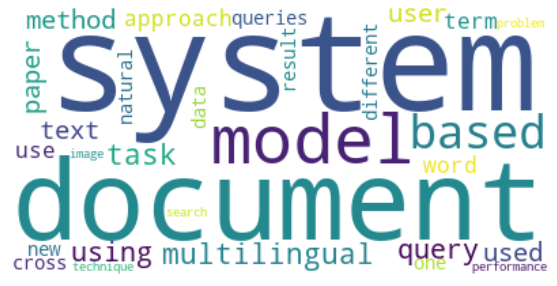

In [ ]:
# Word Cloud

all_abstracts = []
all_titles = []
for conf, papers in retrieval_papers.items():
  for paper, abstract in papers:
    if abstract not in all_abstracts:
      all_abstracts.append(abstract)
    if paper not in all_titles:
      all_titles.append(paper)

abstract_texts = " ".join([abstract for abstract in all_abstracts])
title_texts = " ".join([title for title in all_titles])

stopwords = set(STOPWORDS)
stopwords.update(["languages", "language", "information", 
                  "retrieval", "information retrieval", "English"])

wordcloud1 = WordCloud(max_font_size=100, 
                       max_words=30,
                       #width=500,
                       #height=500, 
                       random_state=1,
                       collocations=True,
                       stopwords=stopwords,
                       min_font_size=8,
                       background_color="white").generate(abstract_texts)
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.show()



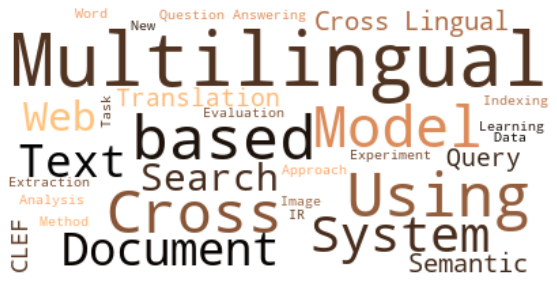

In [ ]:
wordcloud2 = WordCloud(max_font_size=100, 
                       max_words=30,
                       #width=500,
                       #height=500, 
                       random_state=1,
                       collocations=True,
                       stopwords=stopwords,
                       min_font_size = 8,
                       colormap='copper',
                       background_color="white").generate(title_texts)
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Languages studied together

check_languages = list(total_lang_counts.keys())[:40]
check_languages.extend(['Chichewa', 'Somali', 'Swahili'])

languages_together = {}
for language_ in check_languages:
  langs = []
  for conf in retrieval_papers:
    for paper, abstract in retrieval_papers[conf]:
      abstract_ = re.sub(r'[^\w\s]', '', abstract)
      #print(abstract_)
      abstract_ = abstract_.split()
      if language_ in abstract_:
        for item in set(abstract_):
          if item in languages and item not in Unwanted and item != language_: 
            langs.append(item)
  if len(langs) >= 1:
    langs = set([(lang,langs.count(lang)) for lang in langs])
    langs = list(sorted(langs, key=lambda x:x[1], reverse=True))
    languages_together[language_] = langs



In [ ]:
languages_together

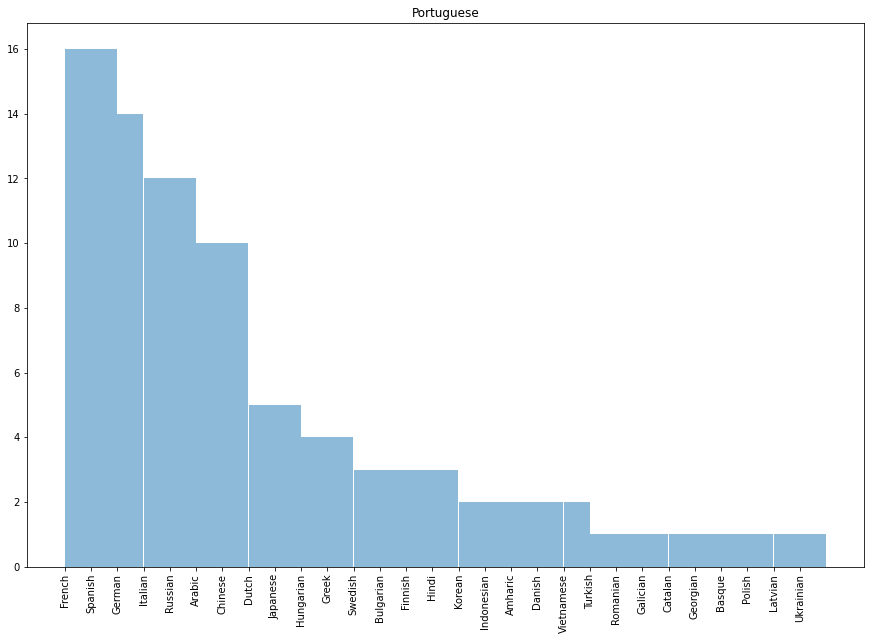

In [ ]:
# To: Plot bar graphs for these languages. Hues represent level of languages (high, 
# medium or low-resource). Label using iso-codes. Include all, but select few labels to show.

to_plot = ['Chinese', 'French', 'Portuguese', 'Hindi', 'Swahili', 'Basque']

counts = [count for lang_, count in languages_together['Portuguese']]
langs = [lang_ for lang_, count in languages_together['Portuguese']]
index = np.arange(len(langs))

plt.figure(figsize=(15, 10))
plt.bar(index, counts, align='edge', width=0.99, alpha=0.5)
plt.xticks(index, langs, fontsize=10, rotation=90)
#plt.ylabel('Count', fontsize=10)
plt.title("Portuguese")
plt.show()

In [ ]:
languages_together['Portuguese']

### Conference Analysis

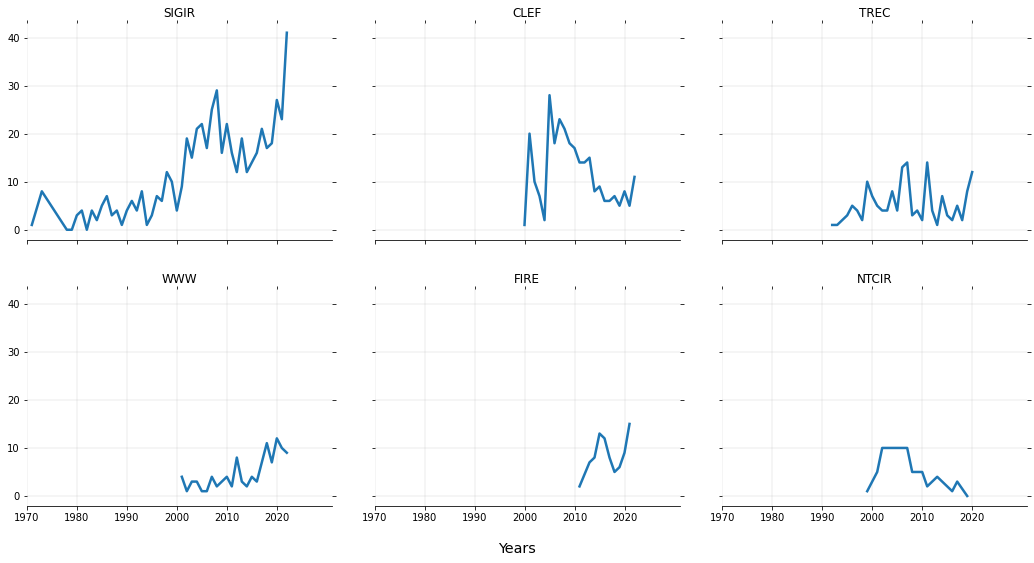

In [21]:
# Conference charts by year

count_per_year = {}

#IR data
for conf, years in data.items():
  count_per_year[conf] = {}
  for year, papers in years.items():
    count = 0
    for paper in papers:
      if "abstract" not in paper or paper["abstract"]==None:
        pass
      else:
        if any(keyword.lower() in paper['abstract'].lower() for keyword 
              in ['language', 'lingual']):
          if 'retriev' in paper['abstract'].lower():
            count += 1
    count_per_year[conf][year] = count

count_per_year.pop('Workshops')
count_per_year.pop('CIKM')
count_per_year.pop('RIAO/OAIR')


top_retr_conf = {conf:sum(years.values()) for conf,years in count_per_year.items()}
top_retr_conf = dict(sorted(top_retr_conf.items(), key=lambda x:x[1], reverse=True))

# Plot trend 1 (From earlier years)
fig1, axes1 = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,8))
#axes1_list = [item for sublist in axes1 for item in sublist]

for ax, conf in zip(axes1.flat, list(top_retr_conf)[:9]):
  #ax = axes1_list.pop(0)
  count_per_year[conf] = dict(sorted(count_per_year[conf].items(), key=lambda x:x[0],
                                     reverse=False))
  x_ = list(count_per_year[conf].keys())
  x_ = [eval(i) for i in x_]
  y_ = list(count_per_year[conf].values())
  ax.set_title(conf)
  ax.plot(x_, y_, linewidth=2.5, label=conf)
  ax.set_title(conf)
  ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
  ax.grid(linewidth=0.25)
  ax.set_xlim((1970, 2031))
  ax.set_xlabel("")
  #ax.set_ylabel("No. of Retrieval Papers", rotation=90)
  ax.set_xticks(range(1970, 2023, 10))
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

"""
# delete anything we didn't use
for ax in axes_list:
  ax.remove()
"""
fig1.text(0.5, 0.0001, 'Years', fontsize='x-large', ha='center')
#fig1.text(0.0001, 0.5, 'Retrieval Papers in Conference', va='center', rotation='vertical')
fig1.tight_layout(pad=3.0)

In [ ]:
# Plot trend 2 (From 2000)
fig1, axes1 = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,8))
#axes1_list = [item for sublist in axes1 for item in sublist]

for ax, conf in zip(axes1.flat, list(top_retr_conf)[3:9]):
  #ax = axes1_list.pop(0)
  count_per_year[conf] = dict(sorted(count_per_year[conf].items(), key=lambda x:x[0],
                                     reverse=False))
  x_ = list(count_per_year[conf].keys())
  x_ = [eval(i) for i in x_]
  y_ = list(count_per_year[conf].values())
  ax.set_title(conf)
  ax.plot(x_, y_, linewidth=2.5, label=conf)
  ax.set_title(conf)
  ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
  ax.grid(linewidth=0.25)
  ax.set_xlim((1980, 2025))
  ax.set_xlabel("")
  #ax.set_ylabel("No. of Retrieval Papers", rotation=90)
  ax.set_xticks(range(1980, 2025, 5))
  ax.set_yticks(range(0, 25, 3))
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

"""
# delete anything we didn't use
for ax in axes_list:
  ax.remove()
"""
fig1.text(0.5, 0.0001, 'Years', fontsize='x-large', ha='center')
#fig1.text(0.0001, 0.5, 'Retrieval Papers in Conference', va='center', rotation='vertical')
fig1.tight_layout(pad=3.5)

In [ ]:
top_retr_conf

In [ ]:
check = [(conf,len(papers)) for conf,papers in retrieval_papers.items()]
check

In [ ]:
count_per_year['WWW']

In [ ]:
# Language Counts By conference
def get_lang_counts(dictionary: dict):
  lang_count = {}
  for conf, papers in dictionary.items():
    languages_count = {}
    for paper, abstract in papers:
      for language in languages:
        #if f" {language.lower()} " in abstract.lower() and len(language.lower()) >= 3:
        if re.search(f"[\s(/-]{language.lower()}[\s,/)\?\.-]", 
                     unidecode(abstract.lower())) and len(language.lower()) >= 3:
          if language not in Unwanted:
            if language in languages_count:
              languages_count[language] += 1
            else:
              languages_count[language] = 1
    lang_count[conf] = dict(sorted(languages_count.items(), 
                                      key=lambda x:x[1], reverse=True))
    
  return lang_count

lang_count_conf = get_lang_counts(retrieval_papers)

In [ ]:
lang_count_conf

In [ ]:
# Check number of languages (or count of language papers) in conferences
conf_all_lang_count = {conf:len(languages.values()) for conf,languages in
                       lang_count_conf.items()}
conf_all_lang_count = dict(sorted(conf_all_lang_count.items(), 
                                  key=lambda x:x[1], reverse=True))
conf_all_lang_count

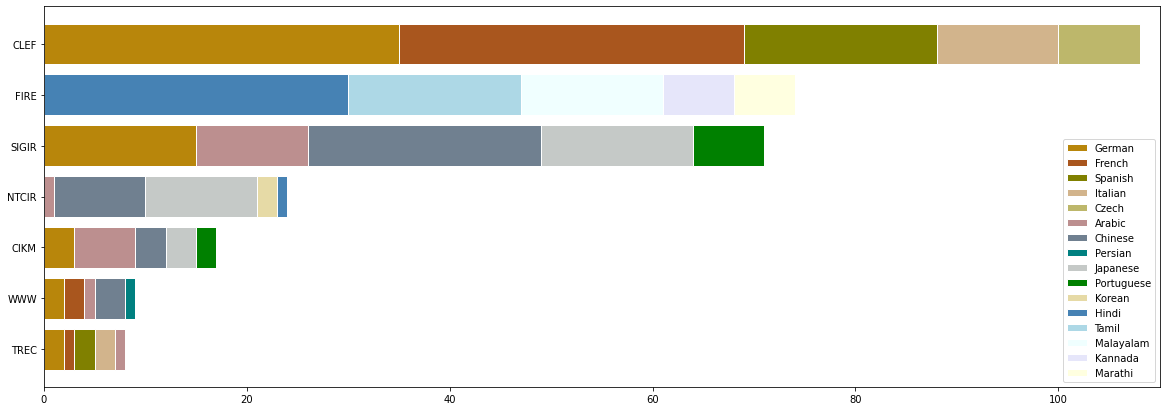

In [ ]:
# Plot stacked bar chart of top languages in conferences

sum_top_five = {}
for conf, languages in lang_count_conf.items():
  languages = dict(sorted(languages.items(), key=lambda x:x[1], reverse=True))
  sum_top_five[conf] = sum(list(languages.values())[:5])
sum_top_five = dict(sorted(sum_top_five.items(), key=lambda x:x[1], reverse=True))

confs = list(sum_top_five.keys())[:9]
confs.reverse()
confs.remove('Workshops')
confs.remove('others')
languages_counts = {}
for i, conf in enumerate(confs):
  for lang, count in list(sorted(lang_count_conf[conf].items(), 
                                 key=lambda x:x[1], reverse=True))[:5]:                            
    if lang not in languages_counts:
      languages_counts[lang] = [0] * 7
      languages_counts[lang][i] = count
    else:
      languages_counts[lang][i] = count
languages_counts = dict(sorted(languages_counts.items(), key=lambda x:x[1][6],
                                reverse=True))
#plot
barWidth = 1
NUM_COLORS = 20

langs = list(languages_counts.keys())
new_colours = ['darkgoldenrod', '#A9561E', 'olive', 'tan', 'darkkhaki',
           'rosybrown', 'slategray', 'teal', '#C5C9C7', '#008000', 
           '#E6DAA6', 'steelblue', '#ADD8E6', '#F0FFFF', '#E6E6FA','lightyellow']
colours_dict = {lang:colour for lang,colour in list(zip(langs,new_colours))}

#cm1 = plt.get_cmap('tab20b')
#cm2 = plt.get_cmap('tab20c')
#colours2 = [cm1(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
#cm2_colours = [cm2(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
#colours2.extend(cm2_colours)
#random.shuffle(colours2)

hatches = ['/' , '\\' , '|' , '-' , '+' , 'x', 'o', '++','O', '.', '*',
           '//', '||', '.o', 'xx', '..', '\\\\', '////', ' ', ' ', ' ', 
           ' ', ' ', ' ', ' ']
r = np.arange(len(confs))
plt.figure(figsize=(20,7))
left = np.zeros((7,))
for i, (lang, counts) in enumerate(languages_counts.items()):
  plt.barh(r, counts, left=left, color=colours_dict[lang], edgecolor='white', label=lang)
  left = left + np.array(counts)
plt.legend()

plt.yticks(r, confs)
plt.xlim([0, 110])
plt.show()

In [ ]:
yoruba_papers = get_papers(retrieval_papers, ["Amharic"])
yoruba_papers

In [ ]:
russian_papers_count = {conf:len(papers) for conf,papers in russian_papers.items()}
sum(russian_papers_count.values())
#russian_papers_count

18

In [ ]:
# Check for low-resource languages 
keywords = ['low-resource', 'low resource']
lowres_papers = get_papers(language_papers, keywords)

lowres_papers_count = {conf:len(papers) for conf,papers in lowres_papers.items()}
print(f"Papers with low-resource in Abstract: {sum(lowres_papers_count.values())}")

Papers with low-resource in Abstract: 44


In [ ]:
lowres_papers

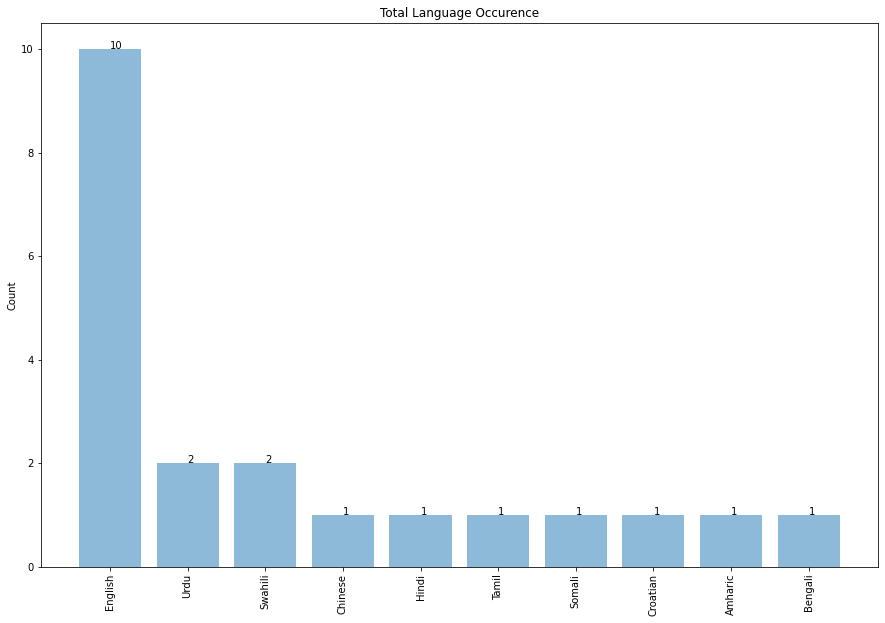

In [ ]:
# Check for languages in low-resource papers

lowres_lang_count_conf = get_lang_counts(lowres_papers)
total_lowres_lang_counts = get_total_lang_count(lowres_lang_count_conf)

# Plot languages by counts
#total_lang_counts_sub = dict(zip(list(total_lowres_lang_counts.keys())[:30], 
#                             list(total_lowres_lang_counts.values())[:30]))
plot_subset(total_lowres_lang_counts, "Total Language Occurence")

In [ ]:
# Check for African languages 
keywords = ['Asian']
afri_papers = get_papers(retrieval_papers, keywords)

afri_papers_count = {conf:len(papers) for conf,papers in afri_papers.items()}
print(f"Papers that mention African languages in Abstract: {sum(afri_papers_count.values())}")

Papers that mention African languages in Abstract: 25


In [ ]:
afri_papers

In [ ]:
afri_papers

In [ ]:
s = "Yanomamö"
unidecode(s)
#s.encode('latin').decode('utf-8')

'Yanomamo'

In [ ]:
# Check for languages in Afro papers

afri_lang_count_conf = get_lang_counts(afri_papers)
total_afri_lang_counts = get_total_lang_count(afri_lang_count_conf)

plot_subset(total_afri_lang_counts, "Total Language Occurence")

In [ ]:
# Check for Indian/Asian languages 
keywords = ['India', 'Asia']
afri_papers = get_papers(language_papers, keywords)

afri_papers_count = {conf:len(papers) for conf,papers in afri_papers.items()}
print(f"Papers that mention African languages in Abstract: {sum(afri_papers_count.values())}")

In [ ]:
import re
doi_reg = r'10\.\d+/[-\.;()/:\w]+'
doi = "https://dx.doi.org/10.1145/3503516"

doi.replace("doi:", "")

'https://dx.doi.org/10.1145/3503516'

In [ ]:
doi = doi.replace("DOI:", "")

In [ ]:
m = re.findall(doi_reg, doi)

In [ ]:
doi.split(m[0])[0].strip()

'https://dx.doi.org/'

In [ ]:
doi_no_abstract = []
no_doi_no_abstract = []
for conf in data:
  for year in data[conf]:
    for paper in data[conf][year]:
      if ("abstract" not in paper or paper["abstract"] == None) and "doi" in paper:
        doi_no_abstract.append(paper)
      if ("abstract" not in paper or paper["abstract"] == None) and "doi" not in paper:
        no_doi_no_abstract.append(paper)

In [ ]:
print(len(doi_no_abstract))
print(len(no_doi_no_abstract))

7236
6477


In [ ]:
no_doi_no_abstract

In [ ]:
import re
pub = "An Empirical Evaluation Of The State Of Art Feature Selection Methods For Text Categorization"

pub = re.sub("([A-Z][.][A-Z][.][,])", "", pub)
pub = re.sub("([A-Z][.][,])", "", pub)
pub = re.sub("([A-Z][.][A-Z][.])", "", pub).replace(".", "").replace('"', "")
pub = re.sub("([A-Z][.])", "", pub).replace("’", "").replace("'", "")
pub = re.sub("([(][0-9]{4}[)])", "", pub)

pub = pub.replace(' ', '%20')
pub = f"(%22{pub}%22)"
pub

'(%22An%20Empirical%20Evaluation%20Of%20The%20State%20Of%20Art%20Feature%20Selection%20Methods%20For%20Text%20Categorization%22)'

In [ ]:
search_url = "https://api.semanticscholar.org/graph/v1/paper/search?"
r = requests.get(search_url, params=f'query=title:{pub}&limit=1&fields=title,authors,abstract,url')
data = r.json()
data

{'total': 1,
 'offset': 0,
 'data': [{'paperId': '15365b454e9fd2f615c8082b0667996285199669',
   'url': 'https://www.semanticscholar.org/paper/15365b454e9fd2f615c8082b0667996285199669',
   'title': 'An Empirical Evaluation Of The State Of Art Feature Selection Methods For Text Categorization',
   'abstract': 'Feature selection methods select a small subset of the relevant features from the original feature space by eliminating redundant or irrelevant features. In the process it also reduces the dimensionality of the feature space and improves the efficiency of the data mining algorithms. In this paper, sixteen state of art feature selection methods are studied that use different benchmark datasets with respect to text categorization and their performance is summarized. The past research reveals that performance of feature selection methods are dataset specific. In the present work, further experiments are carried out with the state of art feature selection methods for text categorizatio

In [ ]:
data['data'][0]['abstract']

'Feature selection methods select a small subset of the relevant features from the original feature space by eliminating redundant or irrelevant features. In the process it also reduces the dimensionality of the feature space and improves the efficiency of the data mining algorithms. In this paper, sixteen state of art feature selection methods are studied that use different benchmark datasets with respect to text categorization and their performance is summarized. The past research reveals that performance of feature selection methods are dataset specific. In the present work, further experiments are carried out with the state of art feature selection methods for text categorization over a unifying framework of benchmark datasets to evaluate and compare their performance on same standards. The efficiency of the methods is evaluated on the basis of their performance with k-means clustering and KNN classification. The experiments reveal that unsupervised feature selection method of Mult

In [ ]:
new_url = "https://api.semanticscholar.org/v1/paper/"+data["data"][0]["paperId"]
r2 = requests.get(new_url)
data2 = r2.json()
data2['url']

'https://www.semanticscholar.org/paper/15365b454e9fd2f615c8082b0667996285199669'

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
list_stopwords = list(stopwords.words("english"))

pub = [i for item in pub.split(",") for i in item.strip().split()]
#pub = [item for item in pub if item.lower() not in list_stopwords and len(item) > 2]
pub

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['A', 'framework', 'for', 'text', 'categorization']

In [ ]:
import requests
import difflib 
paper_url = "https://api.semanticscholar.org/graph/v1/paper/"
search_url = "https://api.semanticscholar.org/graph/v1/paper/search?"
i = 6
query = "+".join(pub[:i]).lower()

r = requests.get(url=search_url, params=f'query={query}+indexes&limit=3&fields=title,authors,abstract')

data = r.json()
if data["total"] > 1:
  score = []
  for paper in data["data"]:
    temp = difflib.SequenceMatcher(None, paper["title"], pub)
    score.append(temp.ratio())

url2 = paper_url + data["data"][score.index(max(score))]["paperId"]

In [ ]:
data

{'total': 186,
 'offset': 0,
 'next': 3,
 'data': [{'paperId': '15365b454e9fd2f615c8082b0667996285199669',
   'title': 'An Empirical Evaluation Of The State Of Art Feature Selection Methods For Text Categorization',
   'abstract': 'Feature selection methods select a small subset of the relevant features from the original feature space by eliminating redundant or irrelevant features. In the process it also reduces the dimensionality of the feature space and improves the efficiency of the data mining algorithms. In this paper, sixteen state of art feature selection methods are studied that use different benchmark datasets with respect to text categorization and their performance is summarized. The past research reveals that performance of feature selection methods are dataset specific. In the present work, further experiments are carried out with the state of art feature selection methods for text categorization over a unifying framework of benchmark datasets to evaluate and compare thei

In [ ]:
url2

'https://api.semanticscholar.org/graph/v1/paper/15365b454e9fd2f615c8082b0667996285199669'

In [ ]:
#url2 = paper_url + data["data"][0]["paperId"]

r2 = requests.get(url=url2)
data2 = r2.json()
data2["abstract"]

In [ ]:
data2["doi"]

'10.1007/s11042-020-10314-9'

In [ ]:
paper_url = "https://api.semanticscholar.org/v1/paper/"
api_url = paper_url + data2["doi"]
api_url

'https://api.semanticscholar.org/v1/paper/10.1007/s11042-020-10314-9'